In [1]:
import pywren
import boto3
import pickle
import dill
from numpywren.matrix_utils import list_all_keys
import concurrent.futures as fs
import seaborn as sns
import numpywren.lambdapack as lp
from collections import defaultdict


DEFAULT_BUCKET numpywrennsdi2


In [5]:
PROGRAM_ID = "1536904477"
BUCKET = "numpywrennsdi2"

In [6]:
s3_client = boto3.client("s3")

In [7]:
runtime_data = pickle.loads(s3_client.get_object(Bucket=BUCKET, Key="{0}/{1}/runtime.pickle".format("lambdapack", PROGRAM_ID))["Body"].read())

In [8]:
print(runtime_data["program"].program)

In [9]:
pywren_futures = runtime_data["all_futures"]

In [10]:
pywren.wait(pywren_futures)

([<pywren.future.ResponseFuture at 0x7fcd4d113b70>,
 [])

In [11]:
pywren_futures = []
for f in runtime_data["all_futures"]:
    if (isinstance(f, list)):
        pywren_futures += f
    else:
        pywren_futures.append(f)
    

In [12]:
runtime_data_dict = {}
for f in pywren_futures:
    try:
        for msg in f.result()['operator_refs']:
            runtime_data_dict[str(tuple(msg))] = f.result()
    except:
        pass
    

In [13]:
s3_client = boto3.client("s3")


In [14]:
runtime_data = pickle.loads(s3_client.get_object(Bucket=BUCKET, Key="{0}/{1}/runtime.pickle".format("lambdapack", PROGRAM_ID))["Body"].read())

In [15]:
lst = [x for x in list_all_keys(bucket=BUCKET, prefix="{0}/{1}".format("lambdapack", PROGRAM_ID)) if "runtime" not in x]

In [16]:
def download_profiled_block(key, bucket):
    client = boto3.client('s3')
    return dill.loads(client.get_object(Key=key, Bucket=bucket)["Body"].read())


def perf_profile(blocks, num_bins=100):
    READ_INSTRUCTIONS = [lp.OC.S3_LOAD]
    WRITE_INSTRUCTIONS = [lp.OC.S3_WRITE, lp.OC.RET]
    COMPUTE_INSTRUCTIONS = [lp.OC.GENERIC]
    # first flatten into a single instruction list
    instructions_full = [inst for block in blocks for inst in block.instrs]
    instructions = [inst for block in blocks for inst in block.instrs if inst.end_time != None and inst.start_time != None]
    start_times = [inst.start_time for inst in instructions]
    end_times = [inst.end_time for inst in instructions]

    abs_start = min(start_times)
    last_end = max(end_times)
    tot_time = (last_end - abs_start)
    bins = np.linspace(0, tot_time, tot_time)
    total_flops_per_sec = np.zeros(len(bins))
    read_bytes_per_sec = np.zeros(len(bins))
    write_bytes_per_sec = np.zeros(len(bins))
    read_txns = np.zeros(len(bins))
    write_txns = np.zeros(len(bins))
    runtimes = []

    for i,inst in enumerate(instructions):
        if (inst.end_time == None or inst.start_time == None):
          # replay instructions don't always have profiling information...
          continue
        duration = inst.end_time - inst.start_time
        if (inst.i_code in READ_INSTRUCTIONS):
            start_time = inst.start_time - abs_start
            end_time = inst.end_time - abs_start
            start_bin, end_bin = np.searchsorted(bins, [start_time, end_time])
            size = inst.size
            bytes_per_sec = size/duration
            gb_per_sec = bytes_per_sec/1e9
            read_bytes_per_sec[start_bin:end_bin]  += gb_per_sec
            read_txns[start_bin:end_bin] += 1/duration

        if (inst.i_code in WRITE_INSTRUCTIONS):
            start_time = inst.start_time - abs_start
            end_time = inst.end_time - abs_start
            start_bin, end_bin = np.searchsorted(bins, [start_time, end_time])
            size = inst.size
            bytes_per_sec = size/duration
            gb_per_sec = bytes_per_sec/1e9
            write_bytes_per_sec[start_bin:end_bin]  += gb_per_sec
            write_txns[start_bin:end_bin] += 1/duration

        if (False and inst.i_code in COMPUTE_INSTRUCTIONS):
            start_time = inst.start_time - abs_start
            end_time = inst.end_time - abs_start
            start_bin, end_bin = np.searchsorted(bins, [start_time, end_time])
            flops = inst.flops
            flops_per_sec = flops/duration
            gf_per_sec = flops_per_sec/1e9
            total_flops_per_sec[start_bin:end_bin]  += gf_per_sec
        runtimes.append(duration)
    optimes = defaultdict(int)
    opcounts = defaultdict(int)
    computetimes = defaultdict(int)
    computecounts = defaultdict(int)
    offset = instructions[0].start_time
    for inst, t in zip(instructions, runtimes):
      opcounts[inst.i_code] += 1
      optimes[inst.i_code] += t
      if (inst.i_code in COMPUTE_INSTRUCTIONS):
        computetimes[inst.compute] += t
        computecounts[inst.compute] += 1
      IO_INSTRUCTIONS = [lp.OC.S3_LOAD, lp.OC.S3_WRITE, lp.OC.RET]
    print("Average instruction runtimes:")
    for k in optimes.keys():
      print("{0}: {1}s".format(k, optimes[k]/opcounts[k]))
    print("Average Compute runtimes:")
    for k in computetimes.keys():
      print("{0}: {1}s".format(k, computetimes[k]/computecounts[k]))
    return read_txns, write_txns, read_bytes_per_sec, write_bytes_per_sec, total_flops_per_sec, bins , instructions, runtimes



In [17]:
 
executor = fs.ThreadPoolExecutor(64)
futures = []
for key in lst:
    futures.append(executor.submit(download_profiled_block, key, BUCKET))
res = fs.wait(futures)


In [18]:
profiled_blocks = {}
for f in futures:
    try:
        for k,v in f.result().items():
            profiled_blocks[str(k)] = pickle.loads(v)
    except:
        pass
    

In [19]:
list(profiled_blocks.keys())[0]

"(2, {'k': 38, 'j': 7})"

In [20]:
profiled_blocks[str(k)]

In [21]:
profiled_blocks


{"(2, {'k': 38, 'j': 7})": <numpywren.lambdapack.InstructionBlock at 0x7fcd042efa58>,
 "(2, {'k': 15, 'j': 82})": <numpywren.lambdapack.InstructionBlock at 0x7fcd4c608f28>,
 "(2, {'k': 94, 'j': 7})": <numpywren.lambdapack.InstructionBlock at 0x7fcd042ef358>,
 "(2, {'k': 98, 'j': 122})": <numpywren.lambdapack.InstructionBlock at 0x7fcd4cef6c50>,
 "(2, {'k': 29, 'j': 22})": <numpywren.lambdapack.InstructionBlock at 0x7fcd042eff60>,
 "(2, {'k': 106, 'j': 22})": <numpywren.lambdapack.InstructionBlock at 0x7fcd045909b0>,
 "(2, {'k': 111, 'j': 30})": <numpywren.lambdapack.InstructionBlock at 0x7fcd046068d0>,
 "(2, {'k': 16, 'j': 20})": <numpywren.lambdapack.InstructionBlock at 0x7fcd240d5630>,
 "(2, {'k': 16, 'j': 23})": <numpywren.lambdapack.InstructionBlock at 0x7fcd042efdd8>,
 "(2, {'k': 57, 'j': 20})": <numpywren.lambdapack.InstructionBlock at 0x7fcd042eff28>,
 "(2, {'k': 22, 'j': 23})": <numpywren.lambdapack.InstructionBlock at 0x7fcd046062b0>,
 "(2, {'k': 119, 'j': 75})": <numpywren.la

In [22]:
runtime_data_dict


{"(2, {'k': 87, 'j': 96})": {'exec_time': [[1536904498.6137161,
    1536904636.7950974]],
  'executed_messages': [[2, {'j': 96, 'k': 87}],
   [2, {'j': 94, 'k': 111}],
   [2, {'j': 92, 'k': 69}],
   [2, {'j': 7, 'k': 20}],
   [2, {'j': 7, 'k': 112}],
   [2, {'j': 17, 'k': 64}],
   [2, {'j': 121, 'k': 19}],
   [2, {'j': 57, 'k': 62}],
   [2, {'j': 23, 'k': 125}],
   [2, {'j': 121, 'k': 79}],
   [2, {'j': 56, 'k': 79}],
   [2, {'j': 112, 'k': 12}],
   [2, {'j': 61, 'k': 8}],
   [2, {'j': 85, 'k': 82}],
   [2, {'j': 13, 'k': 46}],
   [2, {'j': 59, 'k': 7}],
   [2, {'j': 63, 'k': 54}],
   [2, {'j': 36, 'k': 92}],
   [2, {'j': 40, 'k': 37}],
   [2, {'j': 59, 'k': 96}],
   [2, {'j': 86, 'k': 70}],
   [2, {'j': 106, 'k': 74}],
   [2, {'j': 52, 'k': 98}],
   [2, {'j': 83, 'k': 59}],
   [2, {'j': 52, 'k': 90}],
   [2, {'j': 51, 'k': 76}],
   [2, {'j': 10, 'k': 32}],
   [2, {'j': 91, 'k': 102}],
   [2, {'j': 79, 'k': 12}],
   [2, {'j': 117, 'k': 123}],
   [2, {'j': 44, 'k': 5}],
   [2, {'j': 78,

In [23]:
import numpy as np

In [24]:

start_read = []
end_read = []

start_compute = []
end_compute = []

start_write = []
end_write = []

j = 9
blocks_in_run = []
for op in pywren_futures[j].result()['operator_refs']:
    if (str(op) in profiled_blocks):
        blocks_in_run.append(profiled_blocks[str(op)])
blocks_in_run = sorted(blocks_in_run, key=lambda x: x.instrs[0].start_time)
bins = list(range(int(blocks_in_run[0].start_time), int(blocks_in_run[-1].end_time)))
reading_time = np.zeros(len(bins))
writing_time = np.zeros(len(bins))
computing_time = np.zeros(len(bins))

starts = []
ends = []
rts = []
rts_without_postop = []
tot_reads = []
tot_writes = []
tot_computes = []
tot_read_times = []
tot_compute_times = []
tot_write_times = []
read_instrs = []
compute_instrs = []
write_instrs = []

print("==="*3 + "WORKER {0}".format(j) + "==="*3)
print(blocks_in_run)
for i,b in enumerate(blocks_in_run):

    free_time = 0
    starts.append((b.start_time, i))
    ends.append((b.post_op_end, i))
    rts.append((b.post_op_end - b.start_time))
    print("post_op time", b.post_op_end - b.post_op_start)
    rts_without_postop.append((b.instrs[-1].end_time - b.start_time))
    curr = starts[-1][0]
    reads = 0
    writes = 0
    computes = 0
    read_time = 0
    write_time = 0
    compute_time = 0
    read_times_start = []
    write_times_start = []
    compute_times_start = []

    read_times_end = []
    write_times_end = []
    compute_times_end = []
    free_time = [y.end_time - x.start_time for x,y in zip(b.instrs[:-1], b.instrs[1:])]
    for inst in b.instrs:
        curr = inst.end_time
        duration = inst.end_time - inst.start_time
        start_bin, end_bin = np.searchsorted(bins, [inst.start_time, inst.end_time]) 
        if isinstance(inst, lp.RemoteRead):
            read_instrs.append(inst)
            reads += 1
            read_time += inst.end_time - inst.start_time
            reading_time[start_bin:end_bin] += 1
        elif isinstance(inst, lp.RemoteWrite):
            write_instrs.append(inst)
            writes += 1
            write_time += inst.end_time - inst.start_time
            write_times_start.append(inst.start_time)
            write_times_end.append(inst.end_time)
            writing_time[start_bin:end_bin] += 1
        elif isinstance(inst, lp.RemoteCall):
            compute_instrs.append(inst)
            computes += 1
            compute_time += inst.end_time - inst.start_time
            compute_times_start.append(inst.start_time)
            compute_times_end.append(inst.end_time)
            computing_time[start_bin:end_bin] += 1
    tot_reads.append(reads)
    tot_writes.append(writes)
    tot_computes.append(computes)
    tot_read_times.append(read_time)
    tot_write_times.append(write_time)
    tot_compute_times.append(compute_time)
    #print("free time", free_time)
    #print("free time frac", free_time/(ends[-1][0] - starts[-1][0]))


print("Average num reads", np.mean(tot_reads))
print("Average num writes", np.mean(tot_writes))
print("Average num computes", np.mean(tot_computes))
print("Average block completion time", np.mean(rts))
print("Average block completion time without postop", np.mean(rts_without_postop))

print("Average read times", np.mean(tot_read_times))
print("Average compute times ", np.mean(tot_compute_times))
print("Average write times", np.mean(tot_write_times))
print("Variance read times", np.std(tot_read_times))
print("Variance compute times ", np.std(tot_compute_times))
print("Variance write times", np.std(tot_write_times))
print("Average total real work", np.mean(tot_read_times) + np.mean(tot_compute_times) + np.mean(tot_write_times))
print("Average total read + compute", np.mean(tot_read_times) + np.mean(tot_compute_times))




=========WORKER 9=========
[<numpywren.lambdapack.InstructionBlock object at 0x7fcc2ad86c88>, <numpywren.lambdapack.InstructionBlock object at 0x7fcc2ad869b0>, <numpywren.lambdapack.InstructionBlock object at 0x7fcc2ad7fcf8>, <numpywren.lambdapack.InstructionBlock object at 0x7fcc2ad86198>, <numpywren.lambdapack.InstructionBlock object at 0x7fcc2ad7fd68>, <numpywren.lambdapack.InstructionBlock object at 0x7fcc2ad86dd8>, <numpywren.lambdapack.InstructionBlock object at 0x7fcc2ad7f748>, <numpywren.lambdapack.InstructionBlock object at 0x7fcc2ad8c8d0>, <numpywren.lambdapack.InstructionBlock object at 0x7fcc2ad94e80>, <numpywren.lambdapack.InstructionBlock object at 0x7fcc2ad866a0>, <numpywren.lambdapack.InstructionBlock object at 0x7fcc2ad8c748>, <numpywren.lambdapack.InstructionBlock object at 0x7fcc2ad8ce48>, <numpywren.lambdapack.InstructionBlock object at 0x7fcc2ad94ba8>, <numpywren.lambdapack.InstructionBlock object at 0x7fcc2ad86fd0>, <numpywren.lambdapack.InstructionBlock object at

In [180]:
read_instrs = sorted(read_instrs, key=lambda x: x.start_time)


In [181]:
read_free_time =  [y.end_time - x.start_time for x,y in zip(read_instrs[:-1], read_instrs[1:])]


In [182]:
read_free_time = np.array(read_free_time)

In [183]:
np.mean(read_free_time[read_free_time < 8])


2.2027801704406738

In [184]:
bins = np.arange(read_instrs[0].start_time, read_instrs[-1].end_time)
read_times = np.zeros(len(bins))
compute_times = np.zeros(len(bins))
write_times = np.zeros(len(bins))

In [185]:
for r in read_instrs:
    start,end = np.searchsorted(bins, [r.start_time, r.end_time])
    read_times[start:end] += 1
    
for r in compute_instrs:
    start,end = np.searchsorted(bins, [r.start_time, r.end_time])
    compute_times[start:end] += 1
    
for r in write_instrs:
    start,end = np.searchsorted(bins, [r.start_time, r.end_time])
    write_times[start:end] += 1
    

In [186]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


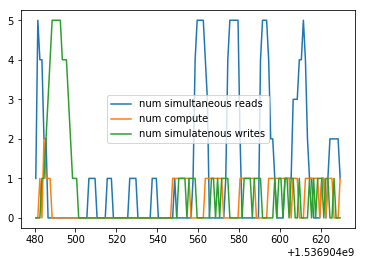

In [33]:
plt.plot(bins, read_times, label="num simultaneous reads")
plt.plot(bins, compute_times, label="num compute")
plt.plot(bins, write_times, label="num simulatenous writes")
#plt.plot(bins, compute_times, label="compute time")
plt.legend()

In [56]:
compute_instrs = sorted(compute_instrs, key=lambda x: x.start_time)

In [57]:
compute_free_time =  [y.end_time - x.start_time for x,y in zip(compute_instrs[:-1], compute_instrs[1:])]

In [58]:
compute_free_time = np.array(compute_free_time)

In [59]:
compute_free_time

array([ 1.65747428,  1.64918613, 53.22834992,  4.36977601,  3.28344727,
        6.34678698,  3.97619939,  3.92968011,  6.69553423,  3.5558641 ,
        3.71732855,  6.02079868,  3.88597417,  4.23275995,  5.23755383,
        4.04397798,  4.1585393 ,  4.53072262,  4.95663619,  3.18344593,
        8.68415046,  3.4958148 ,  9.15434027,  4.9188242 ,  6.23452044,
        5.58194876,  5.60992289,  6.50639343,  5.52644992])

In [109]:
sns.tsplot(reading_time, time=(bins - min(bins)), color="green")
#sns.tsplot(computing_time[60:80], time=(bins - min(bins))[60:80], color="red")
#sns.tsplot(writing_time[60:80], time=(bins - min(bins))[60:80])

TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [ ]:
sns.tsplot(computing_time[start:end], time=(bins - min(bins))[start:end], color="red")

In [ ]:
sns.tsplot(writing_time[start:end], time=(bins - min(bins))[start:end], color="red")

In [ ]:
#plt.hist(rts)
plt.hist(np.array(tot_read_times) + np.array(tot_compute_times) + np.array(tot_write_times))

In [ ]:
plt.scatter(*zip(*start_read), label="start_read")
plt.scatter(*zip(*end_read), label="end_read", alpha=0.8)

plt.scatter(*zip(*start_compute), label="start_compute")
plt.scatter(*zip(*end_compute), label="end_compute", alpha=0.8)
plt.legend()
#plt.xlim(15,20)
plt.ylim(600,700)

In [ ]:
plt.scatter(*zip(*starts))
plt.scatter(*zip(*ends))
plt.figure()
plt.title("runtimes")
plt.scatter(*zip(*rts))

In [ ]:

plt.scatter()

In [ ]:
fig.axes


In [ ]:
np.searchsorted([1,8,9,10], 3)